In [1]:
import sys
import os
# Go three levels up from current file (i.e., from notebooks/ to project/)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
import numpy as np
import matplotlib.pyplot as plt
import utils.mpl_pubstyle  # noqa: F401
import matplotlib.ticker as ticker
import re, glob

# Study stability of IMEX-RB on 2D nonlinear problem
We show absolute stability of IMEX-RB

/tmp/ipykernel_14740/1945912684.py:148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


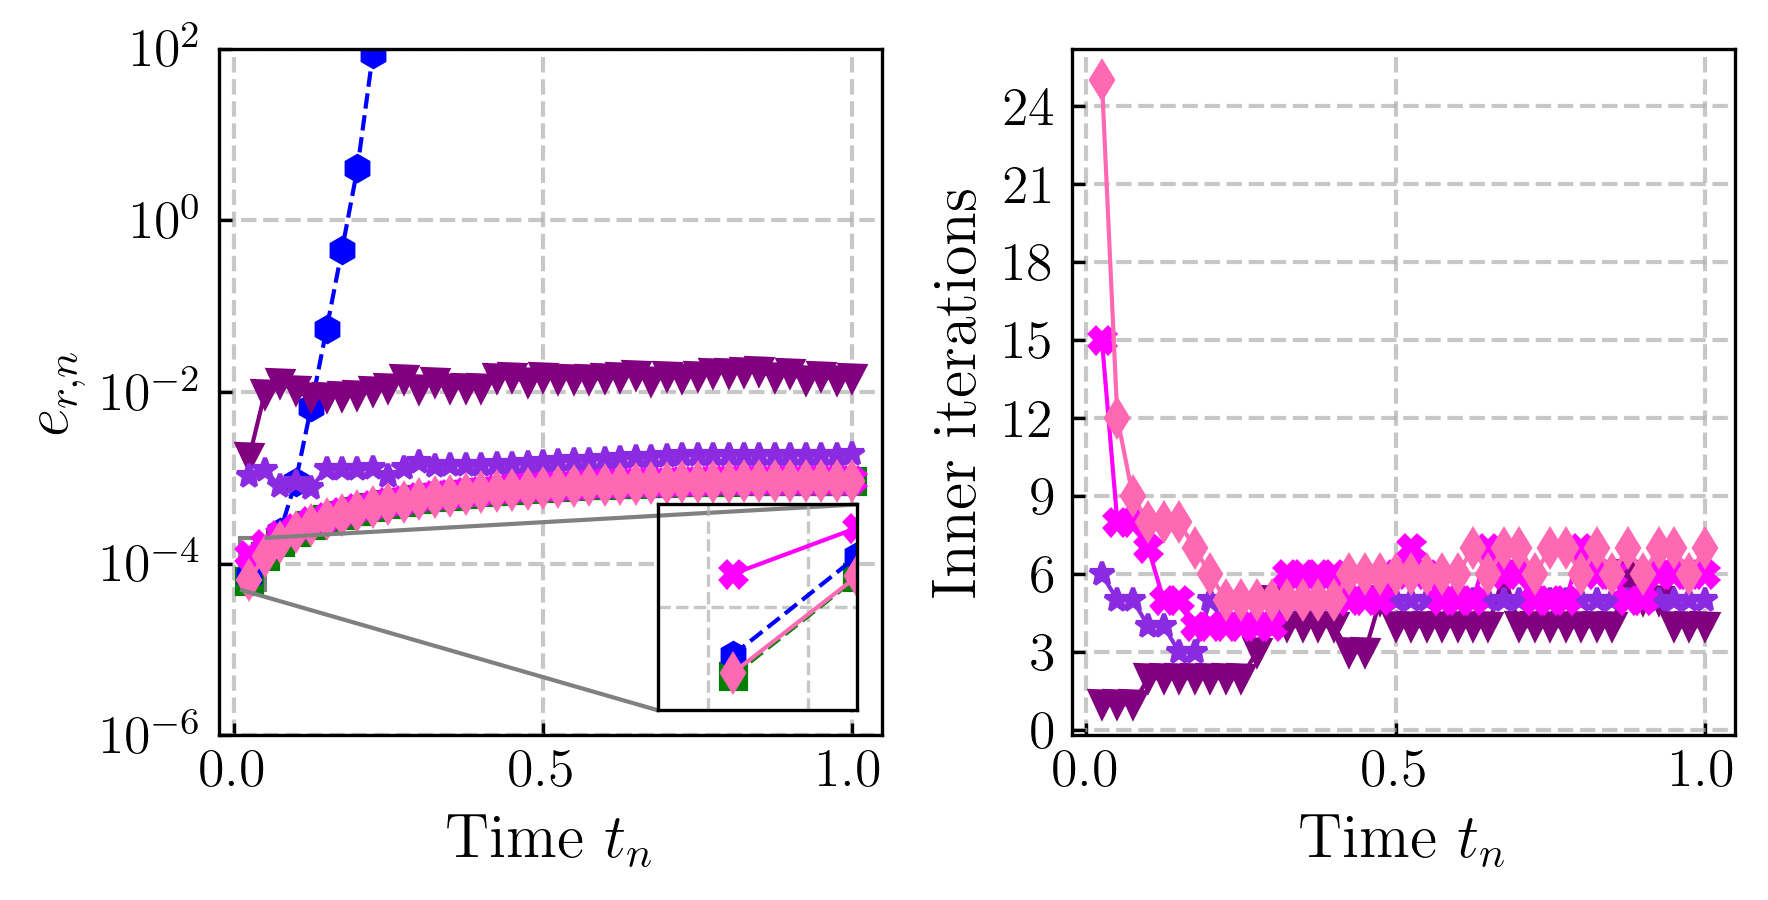

In [3]:

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset


imex_markers = ['v', '*', 'X', 'd', 'o', 'p', 's', 'h']
colors = ['purple', 'blueviolet', 'magenta', 'hotpink', 'red', 'maroon', 'teal', 'orange']

base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))
problem_name = "Burgers2D"
test_name = "stability"
results_base = os.path.join(base_dir, os.pardir, os.pardir, '__RESULTS', problem_name)
convergence_dirs = glob.glob(os.path.join(results_base, f'{test_name}*'))
latest_num = max([int(re.search(rf'{test_name}(\d+)', os.path.basename(d)).group(1)) for d in convergence_dirs])
results_path = os.path.join(results_base, f'{test_name}{latest_num}', 'results.npz')

plots_dir = os.path.join(base_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

data = np.load(results_path, allow_pickle=True)
errors_stability = data['errors_stability'].item()
inneriters = data['inneriters'].item()['IMEX-RB'] + 1
Nt = int(data['Nt'])
tvec = np.linspace(0, 1, Nt + 1)
epsilon_values = data['epsilon_values']

linestyles = ['-.', ':', '-', '--']
method_colors = {'BE': 'green', 'FE': 'blue'}
method_markers = {'BE': 's', 'FE': 'h'}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3.1))
larger_fontsize = 15
smaller_fontsize = 13



# Top: energy error
for m in ('BE', 'FE'):
    e = errors_stability[m]
    ax1.semilogy(
        tvec[1:], e,
        linestyle='--',
        color=method_colors[m],
        marker=method_markers[m],
        markersize=6,
        label=f'{m}'
    )

for ie, eps in enumerate(epsilon_values):
    e = errors_stability['IMEX-RB'][ie]
    ax1.semilogy(
        tvec[1:], e,
        marker=imex_markers[ie],
        markersize=6,
        color=colors[ie],
        linestyle='-',
        label=''
    )
axins = inset_axes(
    ax1,
    width="30%",
    height="30%",
    loc='lower right',
    borderpad=1
)
for m in ('BE', 'FE'):
    e = errors_stability[m]
    axins.semilogy(
        tvec[1:], e,
        linestyle='--',
        markersize=6,
        color=method_colors[m],
        marker=method_markers[m],

    )
for ie, eps in enumerate(epsilon_values):
    e = errors_stability['IMEX-RB'][ie]
    axins.semilogy(
        tvec[1:], e,
        marker=imex_markers[ie],
        markersize=6,
        color=colors[ie],
        linestyle='-',
    )

axins.set_xlim(0.01, 0.05)
axins.set_ylim(5e-5, 2e-4)
axins.tick_params(axis='both', which='both',
                      bottom=False, top=False,
                      left=False, right=False,
                      labelbottom=False, labelleft=False)

mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
ax1.set_ylabel(r'$e_{r,n}$', fontsize=larger_fontsize)
ax1.set_xlabel('Time $t_n$', fontsize=larger_fontsize)
ax1.set_ylim(1e-6, 1e2)
ax1.grid(which='major', linestyle='--', linewidth=1)
ax1.tick_params(axis='both', which='major', labelsize=smaller_fontsize)

# Bottom: inner iterations
for ie, eps in enumerate(epsilon_values):
    expnt = int(np.log10(eps))
    label = rf'IMEX-RB, $\varepsilon=10^{{{expnt}}}$'
    its = inneriters[ie]
    ax2.plot(
        tvec[1:], its,
        marker=imex_markers[ie],
        markersize=6,
        color=colors[ie],
        linestyle='-',
        label=label
    )

ax2.set_xlabel('Time $t_n$', fontsize=larger_fontsize)
ax2.set_ylabel('Inner iterations', fontsize=larger_fontsize)
ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax2.grid(which='major', linestyle='--', linewidth=1)
ax2.tick_params(axis='both', which='major', labelsize=smaller_fontsize)

# External legend


# Create handles and labels for the legend
handles = []
labels = []

# Add BE and FE
for m in ('BE', 'FE'):
    handles.append(plt.Line2D([0], [0], color=method_colors[m], marker=method_markers[m], 
                             linestyle='--', markersize=6))
    labels.append(f'{m}')

# Add IMEX-RB
for ie, eps in enumerate(epsilon_values):
    expnt = int(np.log10(eps))
    handles.append(plt.Line2D([0], [0], color=colors[ie], marker=imex_markers[ie], 
                             linestyle='-', markersize=6))
    labels.append(rf'IMEX-RB, $\varepsilon=10^{{{expnt}}}$')


# Create a separate figure for just the legend
figlegend = plt.figure(figsize=(6, 1.5))
figlegend.legend(handles, labels, loc='center', ncol=3, fontsize=smaller_fontsize)

# Save the legend separately
legend_file = os.path.join(plots_dir, f'{problem_name}_stability_legend.pdf')
figlegend.savefig(legend_file, bbox_inches='tight')
plt.close(figlegend)

plt.tight_layout()
out_file = os.path.join(plots_dir, f'{problem_name}_stability_inneriters_eps.pdf')
plt.savefig(out_file, bbox_inches='tight')
plt.show()
plt.close()
